# Ray tracing in the Agulhas current

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import time

import mantaray

from src import *

In [2]:
##########
# -- Define subdomain
##########
lon_min = 16
lon_max = 29.5

lat_min = -42
lat_max = -32


lons_domain = [lon_min, lon_max, lon_max, lon_min, lon_min]
lats_domain = [lat_min, lat_min, lat_max, lat_max, lat_min]

##########
# -- Define the starting line for ray tracing computation
##########
x_line = [10_000, 400_000]
y_line = [200_000, 100_000]
num_points = 500  # Number of points to sample along the starting line (= number of rays)


depth0 = 4000 # constant depth for this case

### Load Data

In [3]:
ds_current = xr.open_dataset('/Users/gwen29360/Downloads/20160104000000-GLOBCURRENT-L4-CURgeo_0m-ALT_OI-v03.0-fv01.0.nc')
ds_current['current_speed'] = (ds_current.eastward_geostrophic_current_velocity**2 + ds_current.northward_geostrophic_current_velocity**2)**(1/2)

# Next step: have a smoother grid in order to get more rays

# longitude_new = np.linspace(ds_current.lon.values.min(), ds_current.lon.values.max(), 500)
# latitude_new = np.linspace(ds_current.lat.values.min(), ds_current.lat.values.max(), 500)
# ds_current = ds_current.interp(lon = longitude_new, lat = latitude_new, method = 'linear')
sub_ds_current = ds_current.sel(lon = slice(lon_min, lon_max), lat = slice(lat_min, lat_max))

In [4]:
# --- Convert lon/lat to meter/meter
Lon_meter = ((sub_ds_current.lon.values-np.mean(sub_ds_current.lon.values))*1_852*60*np.cos(np.mean(sub_ds_current.lat.values)*np.pi/180))
Lat_meter = ((sub_ds_current.lat.values-np.mean(sub_ds_current.lat.values))*1_852*60)

Lon_meter += Lon_meter.max()
Lat_meter += Lat_meter.max()


### Plot

Text(0.5, 0, 'Current Speed [m/sec]')

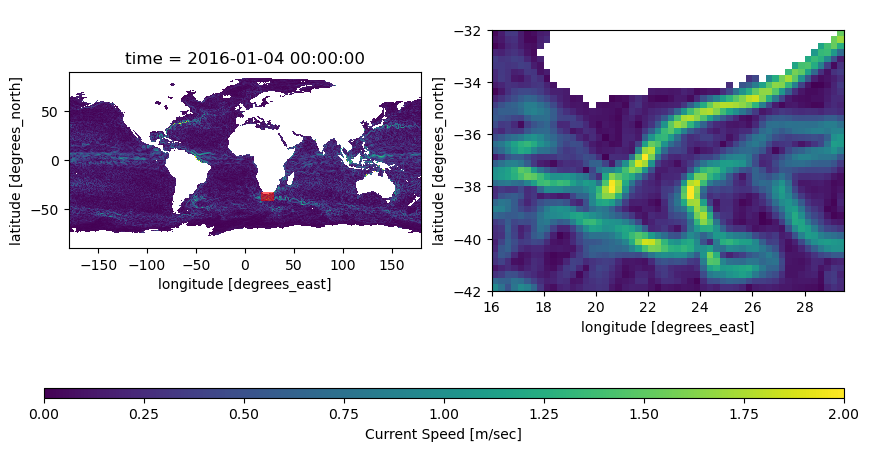

In [5]:
fig, axes = plt.subplots(ncols = 2, figsize = (10, 5))
ax = axes[0]
ds_current.current_speed.squeeze().plot(ax =ax, vmin = 0, vmax = 2, add_colorbar = False)
ax.fill_between(lons_domain, lats_domain, facecolor = 'r', alpha = .6)
ax.set_aspect('equal', 'box')

ax = axes[1]
p2 = sub_ds_current.current_speed.squeeze().plot(ax = ax, vmin = 0, vmax = 2, add_colorbar = False)
cax = fig.add_axes([.1, .02, .8, 0.02])
cbar = plt.colorbar(p2, cax = cax, orientation = 'horizontal')
ax.set_aspect('equal', 'box')
ax.set_title(' ')
cbar.ax.set_xlabel('Current Speed [m/sec]')

In [6]:
closest_x, closest_y = start_line_ray_tracing(x_line, y_line,  Lon_meter, Lat_meter, num_points) # starting locations

### Create forcings for ray tracing

In [7]:
ucur = sub_ds_current.eastward_geostrophic_current_velocity.values.squeeze()
vcur = sub_ds_current.northward_geostrophic_current_velocity.values.squeeze()

In [8]:
output_file_cur = "/Users/gwen29360/Desktop/ray_tracing/data/current_agulhas.nc"
output_file_depth =  "/Users/gwen29360/Desktop/ray_tracing/data/bathy_agulhas.nc"
# create_current_forcing(Lon_meter, Lat_meter, ucur, vcur, output_file_cur, output_file_depth, depth =  depth0)




### Perform the ray tracing

In [10]:
lambda_p = 156 # (= 10 sec waves)
incident_wave_dir = 60 * np.pi/180
k = 2*np.pi/lambda_p


f = frequency_from_wavelength(lambda_p, depth0)
cg = group_velocity(k, f, depth0)

# Period of incident waves in seconds
T0 = 1/f

# Direction of incident waves in radians (trig convention, going to)
theta0 = incident_wave_dir
# Convert period to wavenumber magnitude
k0 = 2*np.pi/lambda_p

# Calculate wavenumber components
kx0 = k0*np.cos(theta0)
ky0 = k0*np.sin(theta0)

# Number of rays
n_rays = num_points
# Initialize wavenumber for all rays
Kx0 = kx0*np.ones(n_rays)
Ky0 = ky0*np.ones(n_rays)

# Current and bathymetry file path
current = output_file_cur
bathymetry = output_file_depth

# Read x and y from file to get domain size
ds = xr.open_dataset(current)

x = ds.x.values
y = ds.y.values

# Starting points
x0 = closest_x
y0 = closest_y


# Estimates CFL
# Computes grid smallest spacing
dd = np.min([np.diff(x).mean(), np.diff(y).mean()])
# Computes group velocity
cg = group_velocity(k0, f, depth0)
# Computes CFL
cfl = dd/cg

duration = round(x.max()/cg)
step_size = cfl

In [12]:
t = time.time()
bando = mantaray.ray_tracing(x0, y0, Kx0, Ky0, duration, step_size, bathymetry, current)
# do stuff
elapsed = time.time() - t
print(f'{n_rays} rays computed in {elapsed} sec')

500 rays computed in 0.08273983001708984 sec


In [40]:
id_rays1 = np.array(np.arange(0, 370, 1), dtype = int)
id_rays2 = np.array(np.arange(380, 500, 1), dtype = int)
id_ray_final = np.concatenate([id_rays1, id_rays2])


### Final Plot

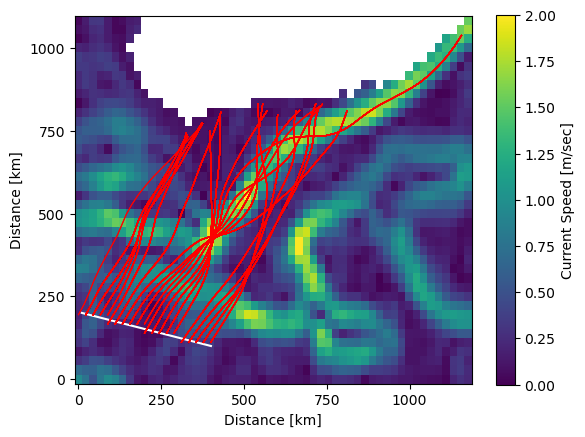

In [41]:
fig, ax = plt.subplots()

ax.plot(x_line, y_line, color = 'w')

cs = ax.pcolormesh(Lon_meter, Lat_meter, (ds.u**2 + ds.v**2)**(1/2), vmin = 0, vmax = 2)
for i in id_ray_final:
    ray = bando.isel(ray=i)
    ax.plot(ray.x, ray.y, 'r', lw=.78)
cbar = plt.colorbar(cs, orientation = 'vertical')
cbar.ax.set_ylabel('Current Speed [m/sec]')
ax.set_xlabel('Distance [km]')
ax.set_ylabel('Distance [km]')

ax.set_yticks([0, 250_000, 500_000, 750_000, 1_000_000])
ax.set_xticks([0, 250_000, 500_000, 750_000, 1_000_000])

ax.set_yticklabels([0, 250, 500, 750, 1_000])
ax.set_xticklabels([0, 250, 500, 750, 1_000])

ax.set_aspect('equal', 'box')